# Dask on an AWS EMR Cluster

This notebook is intended to be run on an AWS EMR cluster, configured using the steps listed in dask_bootstrap_workflow.md tutorial in this lab directory. The EMR cluster used in this tutorial has two worker m5.xlarge instances within it, each of which has 4 virtual CPU cores and 16 GB of memory (you're welcome to scale your cluster beyond this, though!). If you would like to learn more about working with Dask on EMR clusters, [check out the dask-yarn documentation](https://yarn.dask.org/en/latest/aws-emr.html).

In [7]:
from dask_yarn import YarnCluster
from dask.distributed import Client

In [15]:
# Create a cluster where each worker has 1 cores and 4 GiB of memory:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 1,
                      worker_memory = "4GiB"
                      )

# Scale cluster out to 8 such workers:
cluster.scale(8)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.21.225:33211
distributed.scheduler - INFO -   dashboard at:                    :45301
distributed.scheduler - INFO - Receive client connection: Client-d2dd3a2c-2534-11eb-b6af-632ed99d0685
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://172.31.21.182:38719', name: dask.worker_3, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.21.182:38719
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://172.31.25.119:40597', name: dask.worker_6, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.25.119:40597
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://172.31.25.119:37545', name: 

Once everyone is registered, we can see our workers, virtual cores, and the amount of memory that our cluster is using overall; we can adjust all of this as need be if it doesn't match our hardware well. You click the link below to show your task graphs and execution status of your code as you run it.

In [18]:
client

Client Scheduler: tcp://172.31.21.225:33211 Dashboard: /proxy/45301/status,Cluster Workers: 7 Cores: 7 Memory: 30.06 GB


To start, let's do some simple Dask array operations to demonstrate how arrays and array operations are split up into equal chunks across our 8 workers:

In [19]:
import dask.array as da

n = len(client.scheduler_info()['workers'])
a = da.ones(100, chunks=int(100/n))
a

dask.array<ones, shape=(100,), dtype=float64, chunksize=(14,), chunktype=numpy.ndarray>

In [22]:
a.sum().compute()

100.0

In [23]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
y = x + x.T
y.mean().compute()

1.0000125081975038

We can also interact with large data sources in S3 via Dask DataFrames, using a lot of the familiar methods we employ in smaller scale applications in Pandas. Here, we read in 10GB of Amazon's customer book data and perform a few simple operations. If you take a look at the Dask task graph while this is running, you can see that our groupby and sum operations are being performed in parallel by our workers.

In [24]:
import dask.dataframe as dd

df = dd.read_parquet("s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet",
                     storage_options={'anon': True, 'use_ssl': False},
                     engine='fastparquet')

In [25]:
helpful_by_star = (df[['star_rating', 'helpful_votes']].groupby('star_rating')
                                                       .sum())
helpful_df = helpful_by_star.compute() # returns Pandas DataFrame
helpful_df

,helpful_votes
star_rating,
1,10985502
2,5581929
3,7021927
4,11100563
5,44825468


We can also plot and explore our data using standard Matplotlib plotting functionality:

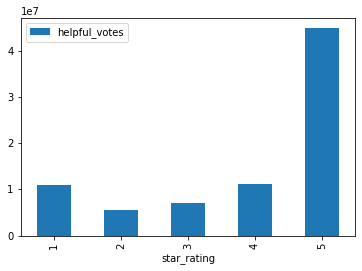

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

helpful_df.plot(kind="bar");